<a href="https://colab.research.google.com/github/majakisan/github-slideshow/blob/master/Copy_of_Recomnd_based_on_Description_and_Genre_06062021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import re
import string
import random

import warnings
warnings.filterwarnings("ignore")

from nltk.corpus import stopwords
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import RegexpTokenizer
from PIL import Image
from io import BytesIO
from sklearn.metrics.pairwise import cosine_similarity

pd.set_option('display.max_rows', 500)

In [ ]:
df = pd.read_csv("books.csv")
df.head(4)

,isbn13,isbn10,title,subtitle,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count
0,9780002005883,0002005883,Gilead,NaN,Marilynne Robinson,Fiction,http://books.google.com/books/content?id=KQZCP...,A NOVEL THAT READERS and critics have been eag...,2004.0,3.85,247.0,361.0
1,9780002261982,0002261987,Spider's Web,A Novel,Charles Osborne;Agatha Christie,Detective and mystery stories,http://books.google.com/books/content?id=gA5GP...,A new 'Christie for Christmas' -- a full-lengt...,2000.0,3.83,241.0,5164.0
2,9780006163831,0006163831,The One Tree,NaN,Stephen R. Donaldson,American fiction,http://books.google.com/books/content?id=OmQaw...,Volume Two of Stephen Donaldson's acclaimed se...,1982.0,3.97,479.0,172.0
3,9780006178736,0006178731,Rage of angels,NaN,Sidney Sheldon,Fiction,http://books.google.com/books/content?id=FKo2T...,"A memorable, mesmerizing heroine Jennifer -- b...",1993.0,3.93,512.0,29532.0


In [ ]:
df['categories'].nunique()

567

In [ ]:
df['categories'].unique()
# it is obvious that some genres are not genres at all like: 'Marple, Jane (Fictitious character)', 'Bracelets'

array(['Fiction', 'Detective and mystery stories', 'American fiction',
       'Christian life', 'Authors, English', 'Africa, East',
       'Hyland, Morn (Fictitious character)', 'Adventure stories',
       'Arthurian romances', 'Fantasy fiction', nan, 'English drama',
       'Country life', 'English fiction', 'Clergy',
       'Aubrey, Jack (Fictitious character)',
       'Detective and mystery stories, English', 'Black Death',
       'Human cloning', 'Science fiction', 'Great Britain',
       'American essays', 'China', 'Capitalism', 'Ireland',
       'Juvenile Fiction', "Children's stories, English",
       'Male friendship', 'Literary Collections',
       'Beresford, Tommy (Fictitious character)',
       'Imaginary wars and battles', 'Dysfunctional families',
       'Poirot, Hercule (Fictitious character)', 'Christmas stories',
       'Marple, Jane (Fictitious character)', 'Belgians',
       'Battle, Superintendent (Fictitious character)',
       'Baggins, Frodo (Fictitious character

In [ ]:
# drop books that have no description
books.dropna(subset=['description'], inplace=True)
#check
books['description'].isna().sum()

0

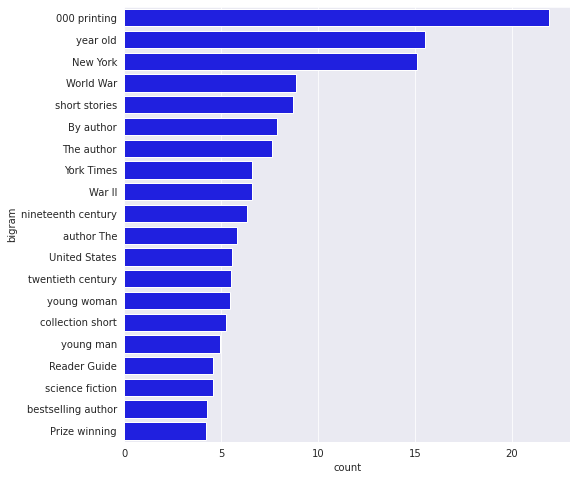

In [ ]:
# description to vectors 
tf = TfidfVectorizer(ngram_range=(2, 2), stop_words='english', lowercase=False)
tfidf_matrix = tf.fit_transform(books['description'])
total_words = tfidf_matrix.sum(axis=0)

# word freq
freq = [(word, total_words[0, index]) for word, index in tf.vocabulary_.items()]
freq = sorted(freq, key=lambda x: x[1], reverse=True)

bigram = pd.DataFrame(freq)
bigram.rename(columns = {0:'bigram', 1: 'count'}, inplace = True) 

# top 20 sequences that have 2 words
bigram = bigram.head(20)

# barplot
plt.figure(figsize=(8, 8))
sns.barplot(x=bigram['count'], y=bigram['bigram'], color='blue')
plt.show()

In [ ]:
#delete number of printings as it is not relevant for genre/description
books = books[~books.description.str.contains('[0-9].*[0-9].*[printing]')]

In [ ]:
# remove non ASCII
def remove_non_ascii(string):
    return "".join(c for c in string if ord(c) < 128)

# put description in lower case
def make_lower_case(text):
    return text.lower()

# remove punctuations
def remove_punctuation(text):
    tokenizer = RegexpTokenizer(r'\w+')
    text = tokenizer.tokenize(text)
    text = " ".join(text)
    return text

# remove html 
def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)

In [ ]:
#add column with 'new' description
books['cleaned_description'] = books['description'].apply(remove_non_ascii)
books['cleaned_description'] = books.cleaned_description.apply(make_lower_case)
books['cleaned_description'] = books.cleaned_description.apply(remove_punctuation)
books['cleaned_description'] = books.cleaned_description.apply(remove_html)

In [ ]:
# make recommendations based on book description

def recommend(title, category):
    
    # make recommendation so that categories/genre matches first
    data = books.loc[books['categories'] == category] 
    # reset index
    data.reset_index(level = 0, inplace = True) 
    indices = pd.Series(data.index, index = data['title'])
    
    # description to vectors 
    tf = TfidfVectorizer(analyzer='word', ngram_range=(2, 2), min_df = 1, stop_words='english')
    tfidf_matrix = tf.fit_transform(data['cleaned_description'])
    
    # find similarity
    similarity = cosine_similarity(tfidf_matrix, tfidf_matrix)
    
    # get the index of the original title
    index = indices[title]
    
    # pair similarity scores
    similarity = list(enumerate(similarity[index]))
    # now sort these books
    similarity = sorted(similarity, key=lambda x: x[1], reverse=True)
    
    # get top 7 most similar
    similarity  = similarity [1:8]
    book_indices = [i[0] for i in similarity]

    # Top 7 to recommend based on their indices
    rec = data[['title', 'thumbnail']].iloc[book_indices]
    print(rec['title'])
    
    # print cover for top 7 recommended books
    for i in rec['thumbnail']:
        response = requests.get(i)
        img = Image.open(BytesIO(response.content))
        plt.figure()
        plt.imshow(img)

1872                A Murder is Announced
652                        The Ruined Map
1184                      Send No Flowers
168     The Third Man and the Fallen Idol
1871                   Evil Under the Sun
1161                          Beach Music
86                     The Fifth Mountain
Name: title, dtype: object


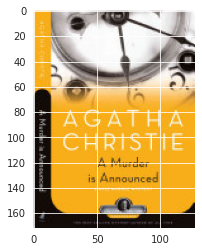

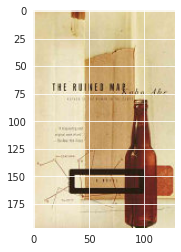

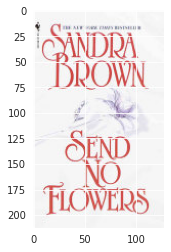

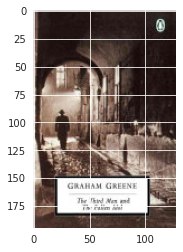

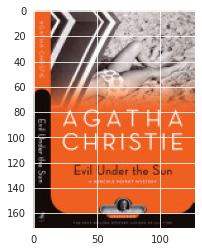

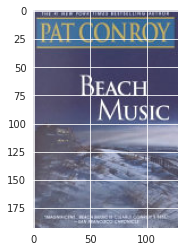

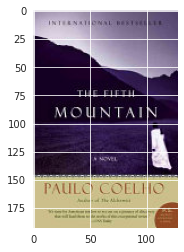

In [ ]:
# test by eneting book title and category
recommend("Taken at the Flood", "Fiction")